In [1]:
import sys
import io
from IPython.display import display, Markdown
import time

class ColabAndFileLogger:
    def __init__(self, filename):
        self.filename = filename
        self.log_file = open(filename, 'w', encoding='utf-8')
        self.buffer = io.StringIO()
        self.original_stdout = sys.stdout # Store the original stdout
        # print(f"DEBUG: Logger initialized. Original stdout type: {type(self.original_stdout)}") # Debug print - removed

    def write(self, message):
        # Debug print to see if write is called and where it's trying to print
        # Note: This debug print itself will also go through the logger after redirection
        # print(f"DEBUG: Writing message (via logger): {message[:50]}...") # Avoid printing large messages
        self.log_file.write(message)
        self.buffer.write(message)
        # Also print to the original stdout for display in Colab
        try:
            self.original_stdout.write(message)
            self.original_stdout.flush() # Ensure it's immediately visible
        except Exception as e:
            # If original_stdout is closed or invalid, we might see an error here
            print(f"DEBUG: Error writing to original stdout: {e}")


    def flush(self):
        self.log_file.flush()
        self.original_stdout.flush()


    def close(self):
        self.log_file.close()
        # No need to restore sys.stdout here as we are printing to original_stdout


output_file_path = 'lung_cancer_prediction_output.txt'
logger = ColabAndFileLogger(output_file_path)
sys.stdout = logger
print("✅ Logger activated.")

start_time = time.time()
print("--- Starting execution time measurement ---")

✅ Logger activated.
--- Starting execution time measurement ---


In [2]:
# @title Utilities
#!pip install scikit-learn-intelex
%pip install imbalanced-learn
%pip install xgboost

In [3]:
# @title Imports and Dependencies
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from sklearn.preprocessing import LabelEncoder , StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, ConfusionMatrixDisplay, f1_score
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from imblearn.over_sampling import SMOTE
import xgboost as xgb
import sys
import os

In [4]:
# @title Data Loading
print("--- Attempting to load the dataset ---")

file_path_local = 'lung_cancer_prediction_dataset.csv'
file_path_drive = '/content/drive/MyDrive/ITCS 3156/Datasets/lung_cancer_prediction_dataset.csv'
local_download_path = '/content/lung_cancer_prediction_dataset.csv' # Define local download path

try:
    print(f"Attempting to load from local path: {file_path_local}")
    df = pd.read_csv(file_path_local)
    print("Dataset loaded successfully from local path.")
except FileNotFoundError:
    print(f"Local file not found at '{file_path_local}'. Attempting to load from Google Drive.")
    try:
        from google.colab import drive
        drive.mount('/content/drive')
        print(f"Attempting to load from Google Drive path: {file_path_drive}")
        df = pd.read_csv(file_path_drive)
        print("Dataset loaded successfully from Google Drive.")

        # Download the file from Drive to the local Colab environment
        print(f"Downloading dataset from Google Drive to {local_download_path}")
        df.to_csv(local_download_path, index=False) # Save the loaded DataFrame to a local CSV
        print("Dataset downloaded to local environment.")

    except FileNotFoundError:
        print(f"Error: Dataset file not found at '{file_path_drive}' on Google Drive. Please ensure the file exists.")
        sys.exit(1)
    except Exception as e:
        print(f"An unexpected error occurred during Google Drive loading: {e}")
        sys.exit(1)
except Exception as e:
    print(f"An unexpected error occurred during local file loading: {e}")
    sys.exit(1)

print(f"\nProceeding with a DataFrame of shape: {df.shape}")

In [5]:
# @title Data Loading and Sampling Configuration

# Use a sample of the dataset
use_sample = True #@param {type:"boolean"}

# Target size of the sample
target_sample_size = 10000 #@param {type:"number"}

# Use a random sample (if False, will use the first N rows)
use_random_sample = True #@param {type:"boolean"}


print("--- Attempting to load the dataset ---")

file_path_local = 'lung_cancer_prediction_dataset.csv'
file_path_drive = '/content/drive/MyDrive/ITCS 3156/Datasets/lung_cancer_prediction_dataset.csv'
local_download_path = '/content/lung_cancer_prediction_dataset.csv' # Define local download path

try:
    print(f"Attempting to load from local path: {file_path_local}")
    df = pd.read_csv(file_path_local)
    print("Dataset loaded successfully from local path.")
except FileNotFoundError:
    print(f"Local file not found at '{file_path_local}'. Attempting to load from Google Drive.")
    try:
        from google.colab import drive
        drive.mount('/content/drive')
        print(f"Attempting to load from Google Drive path: {file_path_drive}")
        df = pd.read_csv(file_path_drive)
        print("Dataset loaded successfully from Google Drive.")

        # Download the file from Drive to the local Colab environment
        print(f"Downloading dataset from Google Drive to {local_download_path}")
        df.to_csv(local_download_path, index=False) # Save the loaded DataFrame to a local CSV
        print("Dataset downloaded to local environment.")

    except FileNotFoundError:
        print(f"Error: Dataset file not found at '{file_path_drive}' on Google Drive. Please ensure the file exists.")
        sys.exit(1)
    except Exception as e:
        print(f"An unexpected error occurred during Google Drive loading: {e}")
        sys.exit(1)
except Exception as e:
    print(f"An unexpected error occurred during local file loading: {e}")
    sys.exit(1)

print("\n--- Dataset Size Selection ---")
original_shape = df.shape[0]
if use_sample and original_shape > target_sample_size:
    if use_random_sample:
        # Create a random sample
        df = df.sample(n=target_sample_size, random_state=42).copy()
        print(f"Selected to use a RANDOM sample of {target_sample_size} rows from the original {original_shape}.")
    else:
        # Use the first N rows
        df = df.head(target_sample_size).copy()
        print(f"Selected to use the FIRST {target_sample_size} rows from the original {original_shape}.")
elif use_sample and original_shape <= target_sample_size:
    print(f"Original dataset has {original_shape} samples, which is less than or equal to the target sample size of {target_sample_size}. Proceeding with the full dataset.")
else:
    print(f"Selected to use the FULL original dataset. Current dataset size: {original_shape} rows.")

print(f"\nProceeding with a DataFrame of shape: {df.shape}")

In [6]:
# @title Data Inspection
print("\n--- Initial Data Inspection ---")
print("Dataset Shape:", df.shape)

print("\nFirst 5 rows of the dataset:")
print(df.head())

print("\nDataset Info:")
df.info()

print("\nDescriptive Statistics for Numerical Features:")
print(df.describe())

In [7]:
# @title Data Cleaning

print("\n--- Columns Cleaning ---")
df.columns = df.columns.str.replace(' ', '_').str.replace('.', '', regex=False).str.replace('/', '_').str.replace('-', '_').str.lower()
print("\n--- Columns after initial cleaning ---")
print(df.columns.tolist())

print("\n--- Initial Missing Values Check ---")
print(df.isnull().sum())

In [8]:
# @title Data Analysis / Feature Selection & Preprocessing

# Columns to drop with high missing values or uneeded values
# 'Cancer_Stage' and 'Treatment_Type' were identified for dropping in ver_2 as well, but this is more explicit.
cols_to_drop = ['cancer_stage', 'treatment_type']

# Dropping these columns from the DataFrame with error handling
df_processed = df.drop(columns=cols_to_drop, errors='ignore')
print(f"\nDropped columns: {cols_to_drop}")
print("New Dataset Shape:", df_processed.shape)

print("\n--- Missing Values Check After Dropping Columns ---")
print(df_processed.isnull().sum())

cols_to_drop_further = ['id', 'population_size', 'annual_lung_cancer_deaths', 'lung_cancer_prevalence_rate', 'mortality_rate', 'survival_years']

df_processed = df_processed.drop(columns=cols_to_drop_further, errors='ignore')
print(f"\nFurther dropped columns: {cols_to_drop_further}")
print("New Dataset Shape after feature selection:", df_processed.shape)
print("\nRemaining columns:", df_processed.columns.tolist())

# Separate target variable first
X = df_processed.drop(columns=['lung_cancer_diagnosis'])
y = df_processed['lung_cancer_diagnosis'] # This is the target, will be encoded below.


# Check for remaining missing values in df_processed
print("\n--- Missing Values Check Before Encoding/Scaling ---")
print(X.isnull().sum()) # X is the feature DataFrame before encoding

# Example: Impute numerical columns if they have NaNs (e.g., mean imputation)
# from sklearn.impute import SimpleImputer
# imputer_numerical = SimpleImputer(strategy='mean')
# for col in numerical_cols: # Re-use or define numerical_cols relevant at this stage
#     if col in X.columns and X[col].isnull().any():
#         X[col] = imputer_numerical.fit_transform(X[[col]])[:,0]
# print("\nMissing values after numerical imputation:")
# print(X.isnull().sum())

# --- Original ver_2 data cleaning (mostly covered by base now) ---
# df['LUNG_CANCER_RISK'] = df['Lung_Cancer_Diagnosis'].apply(lambda x: 1 if x.upper() == 'YES' else 0)
# This mapping is now handled by LabelEncoder on 'lung_cancer_diagnosis' (y_encoded)
# and then used as 'lung_cancer_diagnosis_encoded'. The base code is more general.

# Drop columns with many unique values or missing data that are not useful for the model
# This is largely covered by the `cols_to_drop` and `cols_to_drop_further` in the base code.
# df = df.drop(columns=['ID', 'Country', 'Cancer_Stage', 'Treatment_Type', 'Lung_Cancer_Diagnosis']) # Duplicated/Unneeded. 'Country' is handled by OHE. Target handled by separation.


In [9]:
# @title Encoding Categorical Features

# Encode the target variable (assuming 'Yes'/'No' or similar)
le_target = LabelEncoder()
y_encoded = le_target.fit_transform(y)
print(f"Original 'lung_cancer_diagnosis' classes mapped to: {le_target.classes_} -> {le_target.transform(le_target.classes_)}")

# Binary Categorical Features Encoding (Explicit Mapping)
binary_cols_map = {
    'gender': {'Male': 0, 'Female': 1},
    'smoker': {'No': 0, 'Yes': 1},
    'passive_smoker': {'No': 0, 'Yes': 1},
    'family_history': {'No': 0, 'Yes': 1},
    'adenocarcinoma_type': {'No': 0, 'Yes': 1},
    'occupational_exposure': {'No': 0, 'Yes': 1},
    'indoor_pollution': {'No': 0, 'Yes': 1},
    'early_detection': {'No': 0, 'Yes': 1}
}

for col, mapping in binary_cols_map.items():
    if col in X.columns:
        X[col] = X[col].map(mapping)
        if X[col].isnull().any():
            print(f"Warning: NaNs introduced in column '{col}' during mapping. Check unique values and mapping.")
        print(f"Mapped binary column '{col}'.")

# Ordinal Categorical Features Encoding (Explicit Mapping)
ordinal_cols_map = {
    'air_pollution_exposure': {'Low': 0, 'Medium': 1, 'High': 2},
    'healthcare_access': {'Poor': 0, 'Good': 1}
}

for col, mapping in ordinal_cols_map.items():
    if col in X.columns:
        X[col] = X[col].map(mapping)
        if X[col].isnull().any():
            print(f"Warning: NaNs introduced in column '{col}' during mapping. Check unique values and mapping.")
        print(f"Mapped ordinal column '{col}'.")

# Multi-Category Nominal Features (One-Hot Encoding)
nominal_cols = ['country', 'developed_or_developing']

nominal_cols = [col for col in nominal_cols if col in X.columns]

if nominal_cols:
    X_encoded = pd.get_dummies(X, columns=nominal_cols, drop_first=True)
    print(f"Applied One-Hot Encoding to: {nominal_cols}")
else:
    X_encoded = X.copy()
    print("No multi-category nominal columns for One-Hot Encoding.")

print("\nShape after all Encoding:", X_encoded.shape)
print("First 5 rows of encoded features (X_encoded):")
print(X_encoded.head())

# Scaling Numerical Features
numerical_cols = ['age', 'years_of_smoking', 'cigarettes_per_day']

numerical_cols = [col for col in numerical_cols if col in X_encoded.columns]

scaler = StandardScaler()
X_scaled = X_encoded.copy()
if numerical_cols:
    X_scaled[numerical_cols] = scaler.fit_transform(X_encoded[numerical_cols])
    print(f"Applied StandardScaler to: {numerical_cols}")
else:
    print("No numerical columns found to scale.")

print("\nFirst 5 rows of scaled features (X_scaled):")
print(X_scaled.head())
print("\nDescriptive Statistics for Scaled Numerical Features:")
if numerical_cols:
    print(X_scaled[numerical_cols].describe())

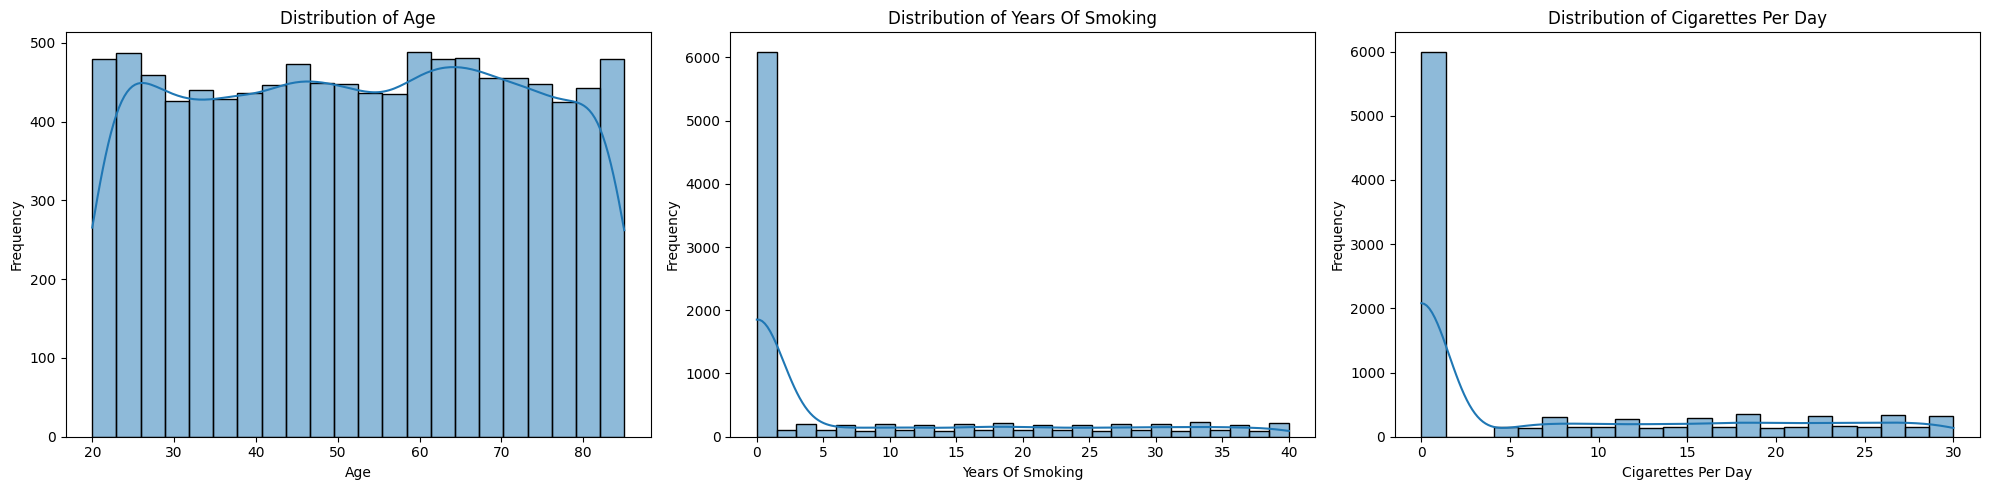

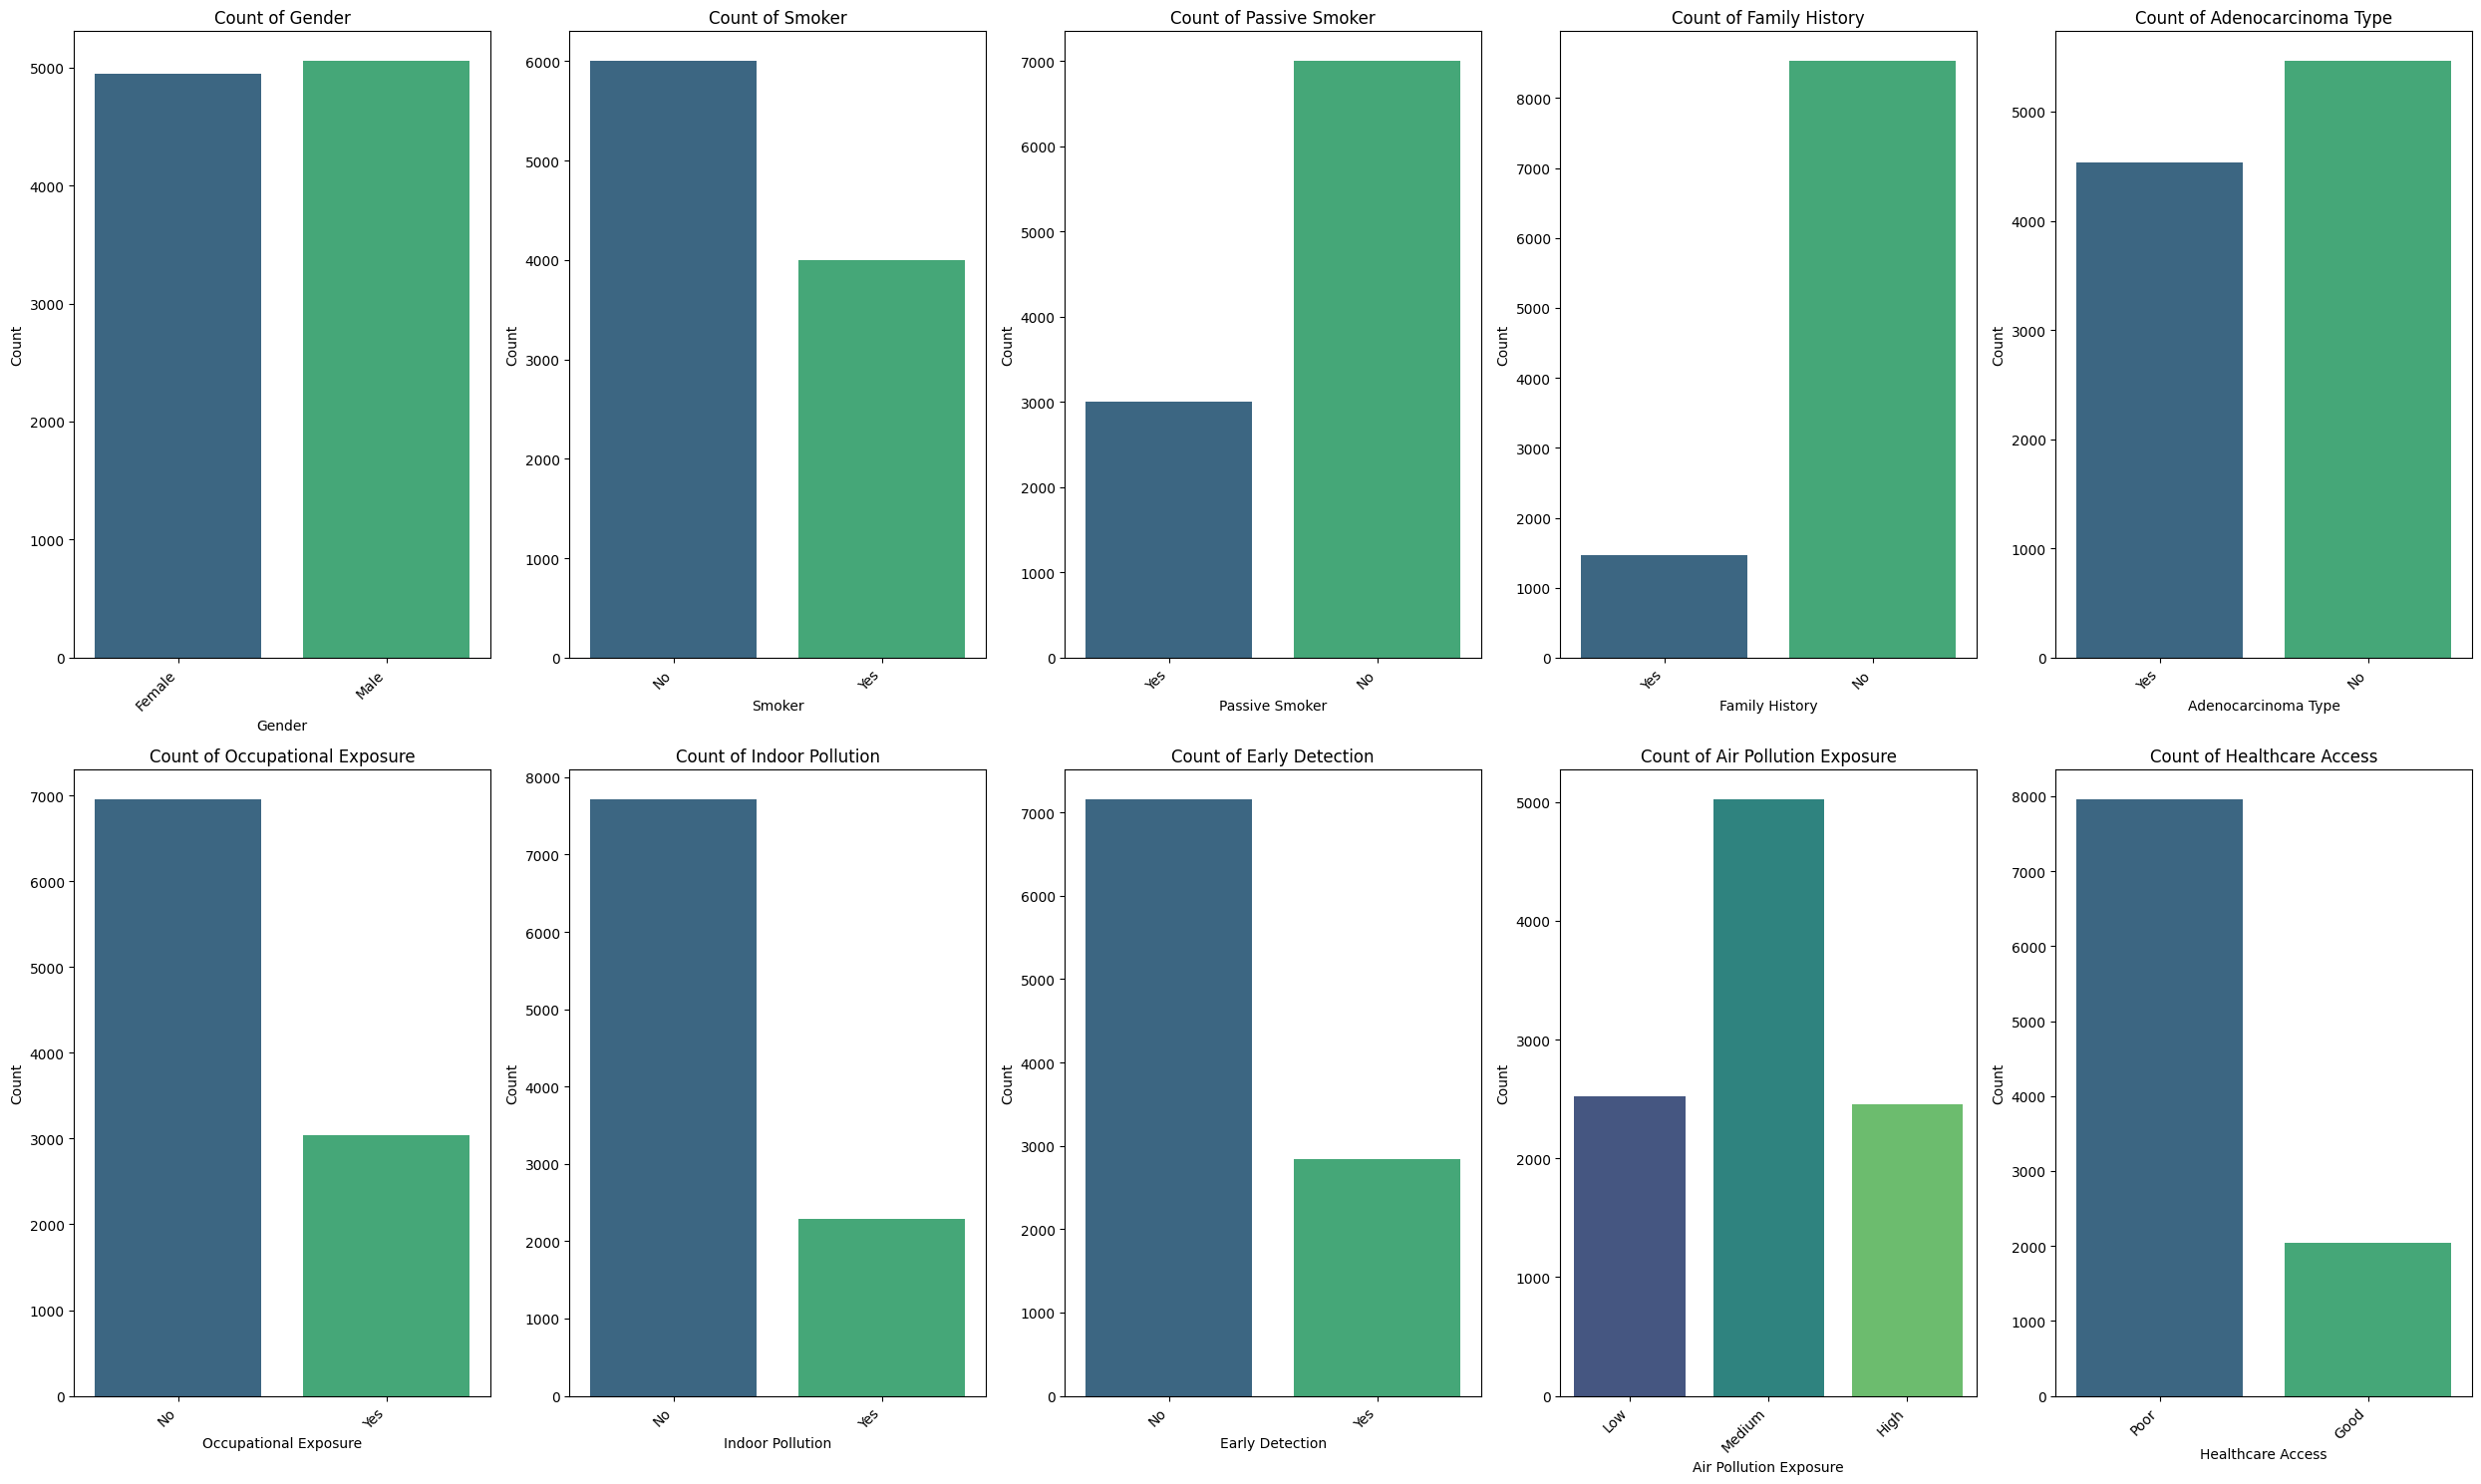

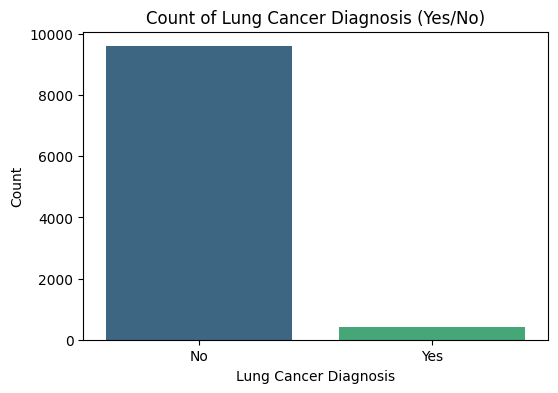

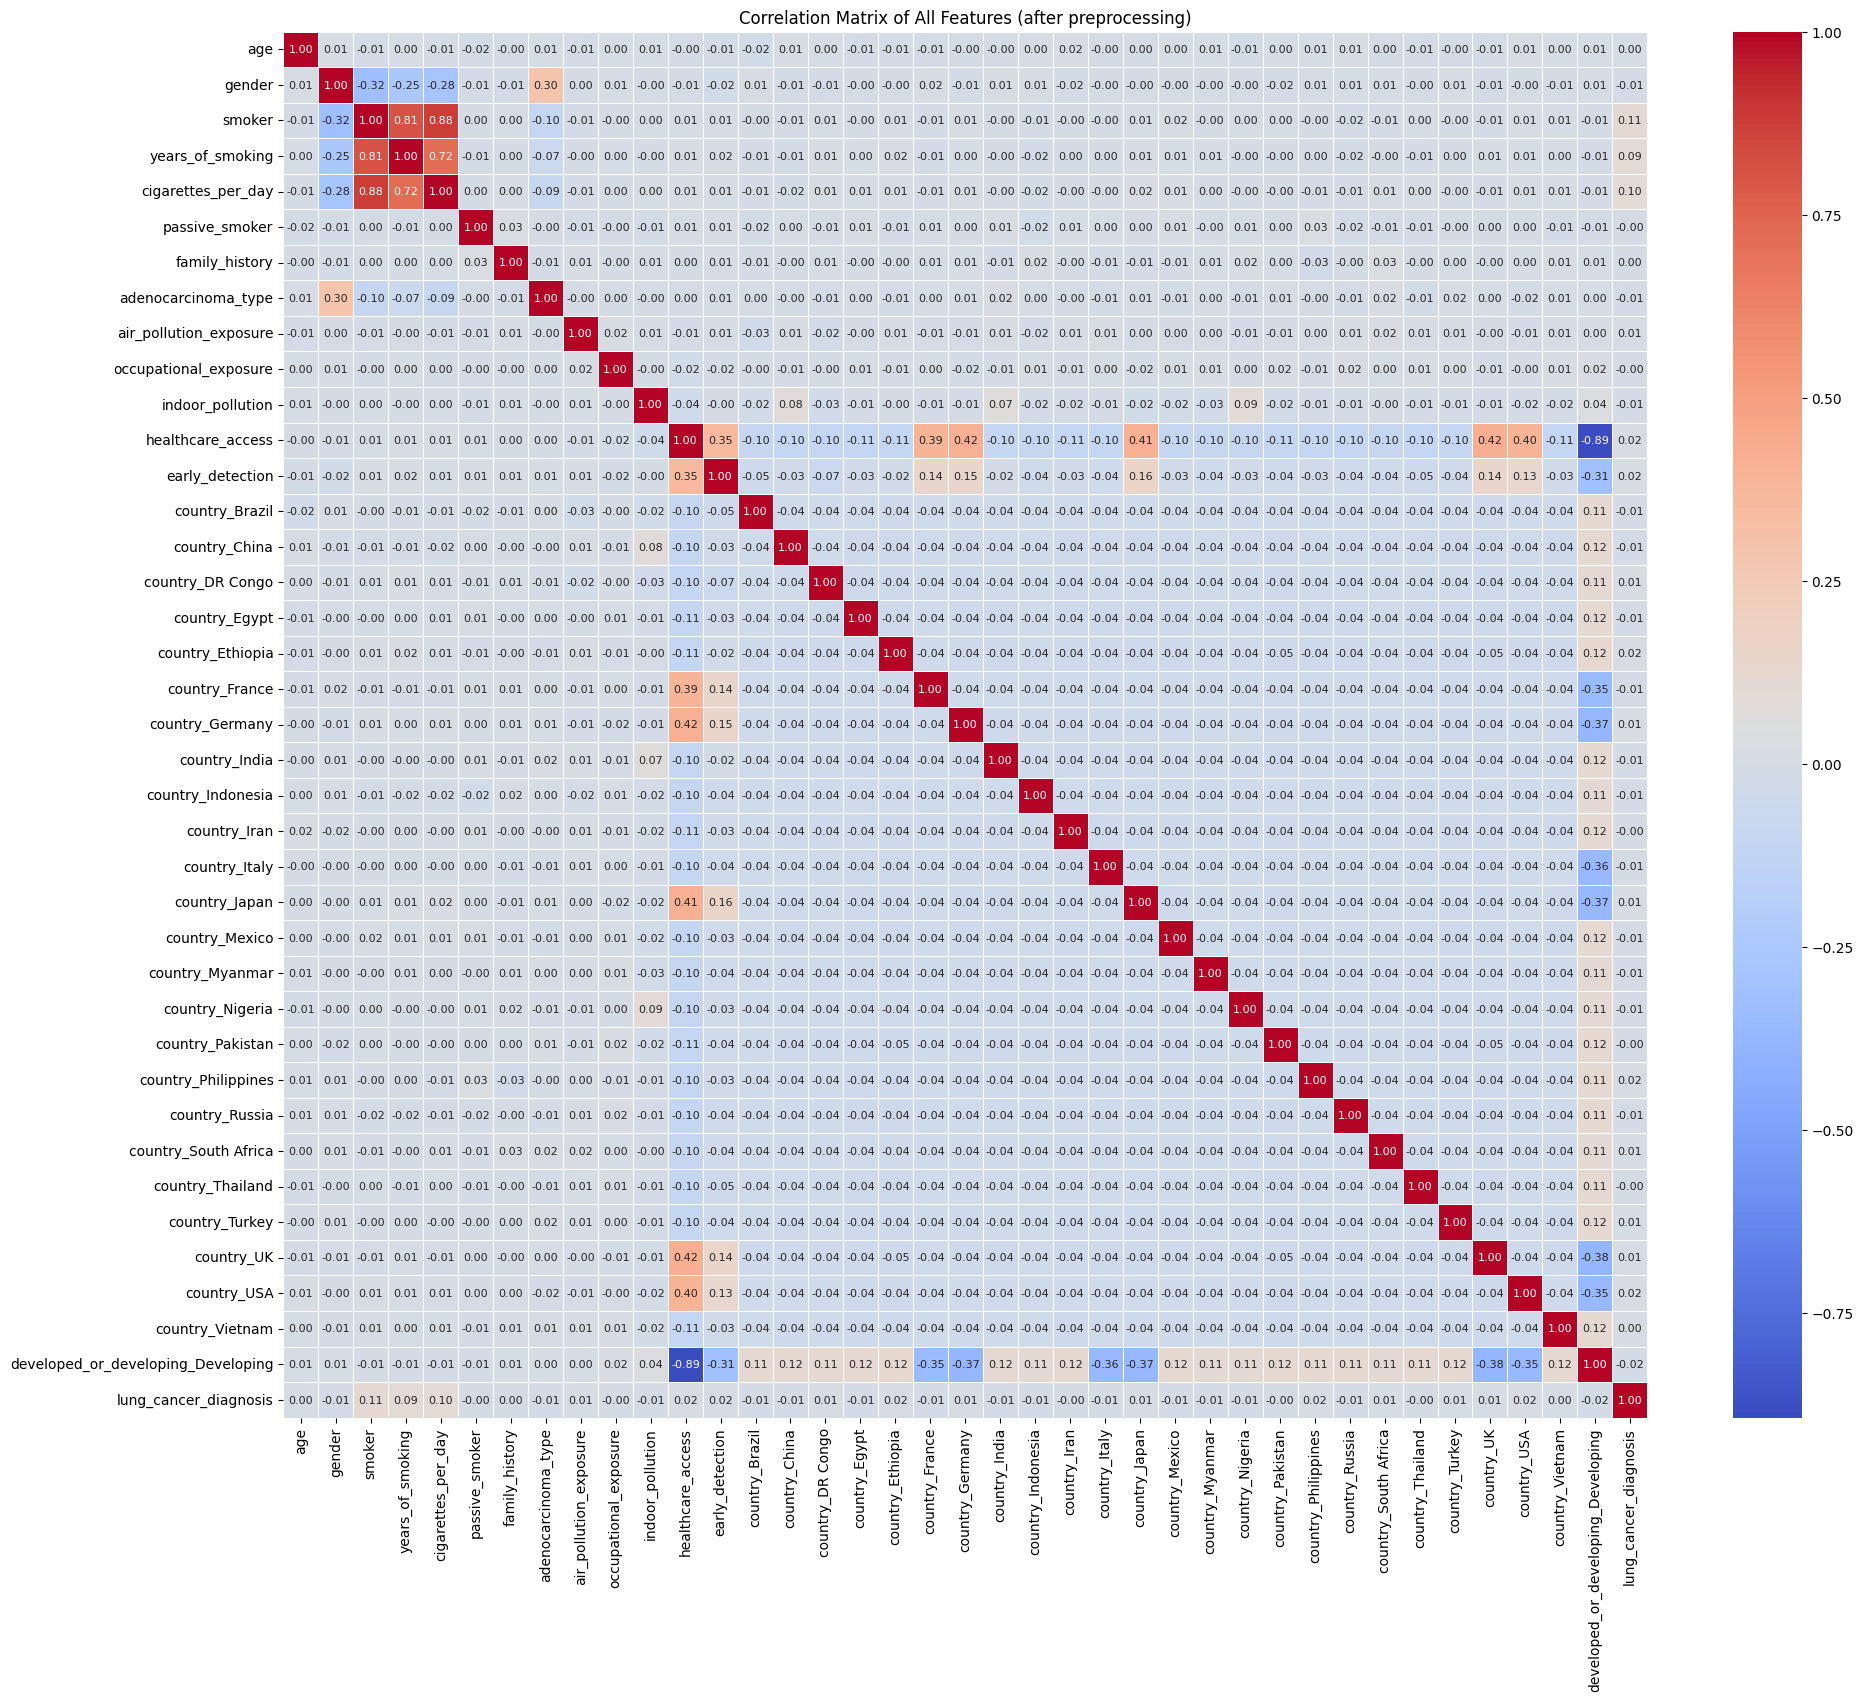

In [10]:
# @title Exploratory Data Analysis (EDA) Plots
print("\n--- Exploratory Data Analysis (EDA) ---")

# Unscaled data for initial EDA (before scaling for model training)
df_eda = df_processed.copy()
df_eda['lung_cancer_diagnosis_encoded'] = y_encoded # Use the encoded target for EDA correlations

# Distribution of Numerical Features
print("\n- Distribution of Numerical Features:")
numerical_cols_for_eda = ['age', 'years_of_smoking', 'cigarettes_per_day']

plt.figure(figsize=(20, 5))
for i, col in enumerate(numerical_cols_for_eda):
    if col in df_eda.columns:
        plt.subplot(1, len(numerical_cols_for_eda), i + 1)
        sns.histplot(df_eda[col], kde=True)
        plt.title(f'Distribution of {col.replace("_", " ").title()}')
        plt.xlabel(col.replace("_", " ").title())
        plt.ylabel('Frequency')
        # Removed plt.tight_layout() here as it's better to call it once per figure
        # Removed plt.show() here

plt.tight_layout() # Call tight_layout once for all subplots in this figure
plt.show() # Show numerical plots once after the loop


# Count Plots for Key Categorical Features (Original, if available)
print("\n- Count Plots for Key Categorical Features:")
categorical_cols_for_eda = ['gender', 'smoker', 'passive_smoker', 'family_history', 'adenocarcinoma_type', 'occupational_exposure', 'indoor_pollution', 'early_detection', 'air_pollution_exposure', 'healthcare_access']

plt.figure(figsize=(25, 15))

for i, col in enumerate(categorical_cols_for_eda):
    # Use original df for raw categorical values if not encoded yet for clearer visualization
    if col in df.columns:
        plt.subplot(2, 5, i + 1) # Keep current subplot layout
        sns.countplot(x=col, data=df, hue=col, palette='viridis', legend=False)
        plt.title(f'Count of {col.replace("_", " ").title()}')
        plt.xlabel(col.replace("_", " ").title())
        plt.ylabel('Count')
        plt.xticks(rotation=45, ha='right') # Rotate x-axis labels for better readability

plt.tight_layout() # Call tight_layout once for all subplots in this figure
plt.show() # Show categorical plots once

# Target Variable Distribution
print("\n- Distribution of Lung Cancer Diagnosis:")
plt.figure(figsize=(6, 4))
sns.countplot(x='lung_cancer_diagnosis', data=df_eda, hue='lung_cancer_diagnosis', palette='viridis', legend=False)
plt.title('Count of Lung Cancer Diagnosis (Yes/No)')
plt.xlabel('Lung Cancer Diagnosis')
plt.ylabel('Count')
plt.show()

# Correlation Heatmap (after encoding and scaling, for model insights)
print("\n- Correlation Heatmap of Features:")
plt.figure(figsize=(22, 18))

# Include the encoded target variable in the correlation matrix for insight
correlation_matrix_df = X_scaled.copy()
correlation_matrix_df['lung_cancer_diagnosis'] = y_encoded

sns.heatmap(correlation_matrix_df.corr(), annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5, annot_kws={"size": 8})
plt.title('Correlation Matrix of All Features (after preprocessing)')
plt.show()

In [11]:
# @title Train/Test Split
# Split the data into training and testing sets
# Usually 80% train, 20% test, or 70/30
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
)

print(f"\nShape of X_train: {X_train.shape}")
print(f"y_train class distribution:\n{pd.Series(y_train).value_counts()}")

In [12]:
# @title Model Training & Evaluation
print("\n--- Model Training & Evaluation ---")

# Define models - Added n_jobs=-1 for parallel processing where applicable
models = {
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1),
    'Logistic Regression': LogisticRegression(n_jobs=-1, random_state=42, max_iter=1000),
#    'SVM': SVC(random_state=42),
    'Linear SVM': LinearSVC(random_state=42, dual=False),
    'Decision Tree': DecisionTreeClassifier(random_state=42),
    'KNN': KNeighborsClassifier(n_jobs=-1),
    'Naive Bayes': GaussianNB(),
    'Gradient Boosting': GradientBoostingClassifier(random_state=42),
    'XGBoost': xgb.XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss', n_jobs=-1)
}

def train_and_evaluate_model(name, model, X_train, y_train, X_test, y_test):
    print(f"\n--- Training and evaluating {name} ---")
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    acc = accuracy_score(y_test, y_pred)
    print(f'{name} Accuracy: {acc:.4f}')

    print(f"Classification Report for {name} :\n", classification_report(y_test, y_pred))

    fig, ax = plt.subplots(figsize=(6, 5))
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['No Cancer', 'Cancer'])
    disp.plot(cmap='Blues', ax=ax)
    plt.title(f'Confusion Matrix - {name}')
    plt.grid(False)
    plt.savefig(f'{name}_Confusion_Matrix.png', bbox_inches='tight') # Saves the plot
    plt.show()
    return name, acc

# Dictionary to store accuracy results
accuracy_results = {}
# Dictionary to store F1-scores
f1_results = {}

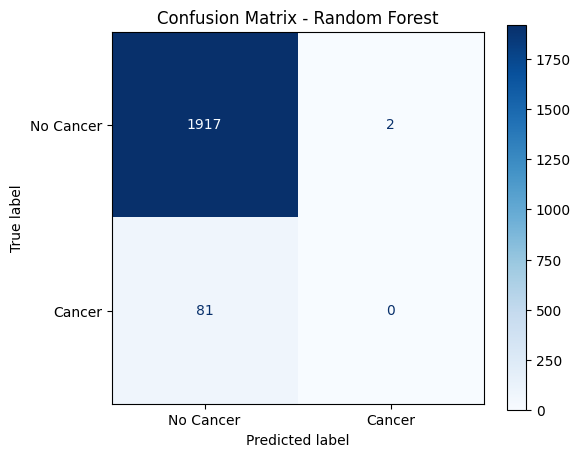

In [13]:
# @title Random Forest Classifier
name, acc = train_and_evaluate_model(
    'Random Forest',
    models['Random Forest'], # Use the pre-defined model instance
    X_train, y_train, X_test, y_test
)
accuracy_results[name] = acc
f1_results[name] = f1_score(y_test, models['Random Forest'].predict(X_test))

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


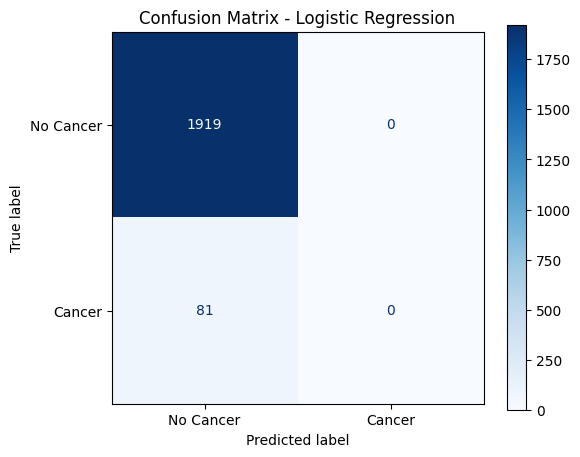

In [14]:
# @title Logistic Regression
name, acc = train_and_evaluate_model(
    'Logistic Regression',
    models['Logistic Regression'],
    X_train, y_train, X_test, y_test
)
accuracy_results[name] = acc
f1_results[name] = f1_score(y_test, models['Logistic Regression'].predict(X_test))

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


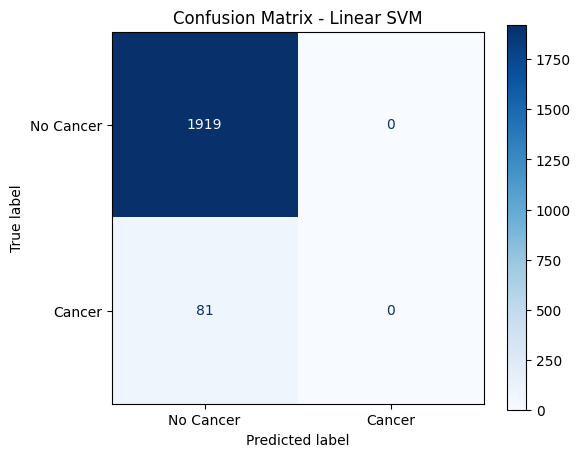

In [15]:
# @title Linear SVM
name, acc = train_and_evaluate_model(
    'Linear SVM',
    models['Linear SVM'],
    X_train, y_train, X_test, y_test
)
accuracy_results[name] = acc
f1_results[name] = f1_score(y_test, models['Linear SVM'].predict(X_test))

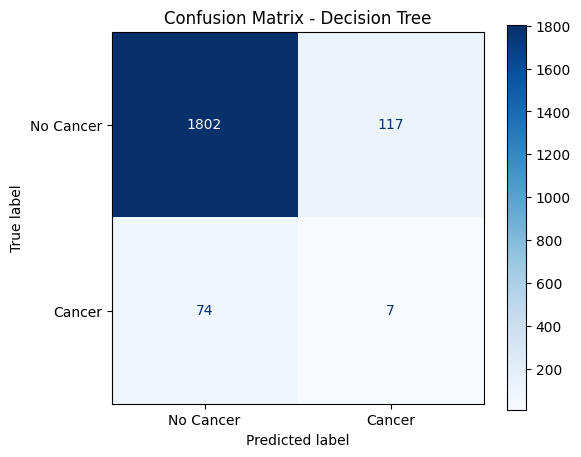

In [16]:
# @title Decision Tree Classifier
name, acc = train_and_evaluate_model(
    'Decision Tree',
    models['Decision Tree'],
    X_train, y_train, X_test, y_test
)
accuracy_results[name] = acc
f1_results[name] = f1_score(y_test, models['Decision Tree'].predict(X_test))

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


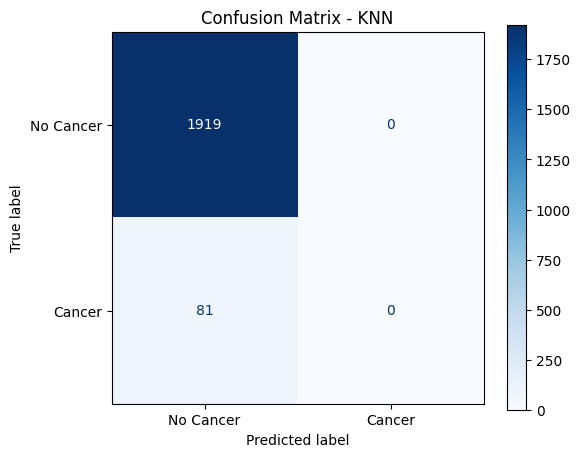

In [17]:
# @title K-Nearest Neighbors (KNN)
name, acc = train_and_evaluate_model(
    'KNN',
    models['KNN'],
    X_train, y_train, X_test, y_test
)
accuracy_results[name] = acc
f1_results[name] = f1_score(y_test, models['KNN'].predict(X_test))

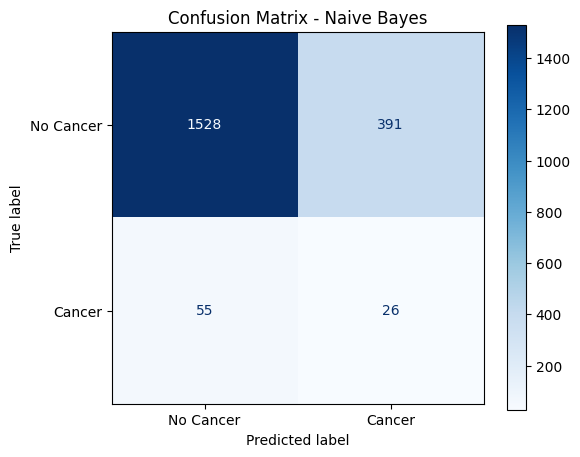

In [18]:
# @title Gaussian Naive Bayes
name, acc = train_and_evaluate_model(
    'Naive Bayes',
    models['Naive Bayes'],
    X_train, y_train, X_test, y_test
)
accuracy_results[name] = acc
f1_results[name] = f1_score(y_test, models['Naive Bayes'].predict(X_test))

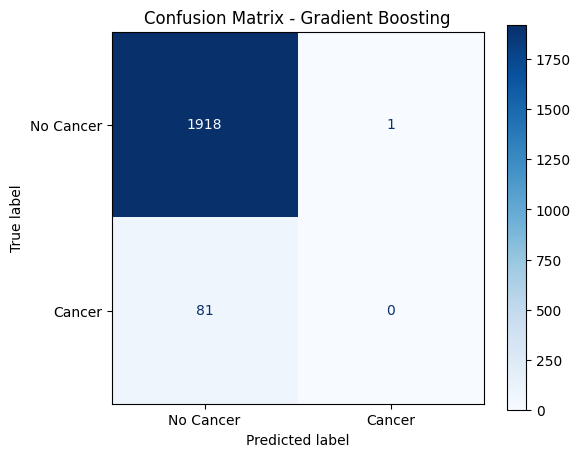

In [19]:
# @title Gradient Boosting Classifier
name, acc = train_and_evaluate_model(
    'Gradient Boosting',
    models['Gradient Boosting'],
    X_train, y_train, X_test, y_test
)
accuracy_results[name] = acc
f1_results[name] = f1_score(y_test, models['Gradient Boosting'].predict(X_test))

/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [17:51:16] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


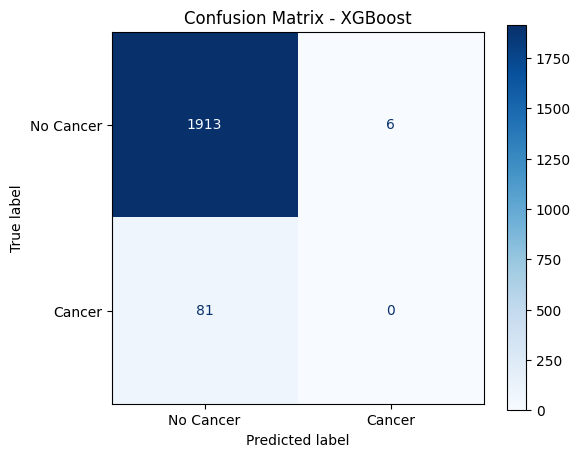

In [20]:
# @title XGBoost
name, acc = train_and_evaluate_model(
    'XGBoost',
    models['XGBoost'],
    X_train, y_train, X_test, y_test
)
accuracy_results[name] = acc
f1_results[name] = f1_score(y_test, models['XGBoost'].predict(X_test))

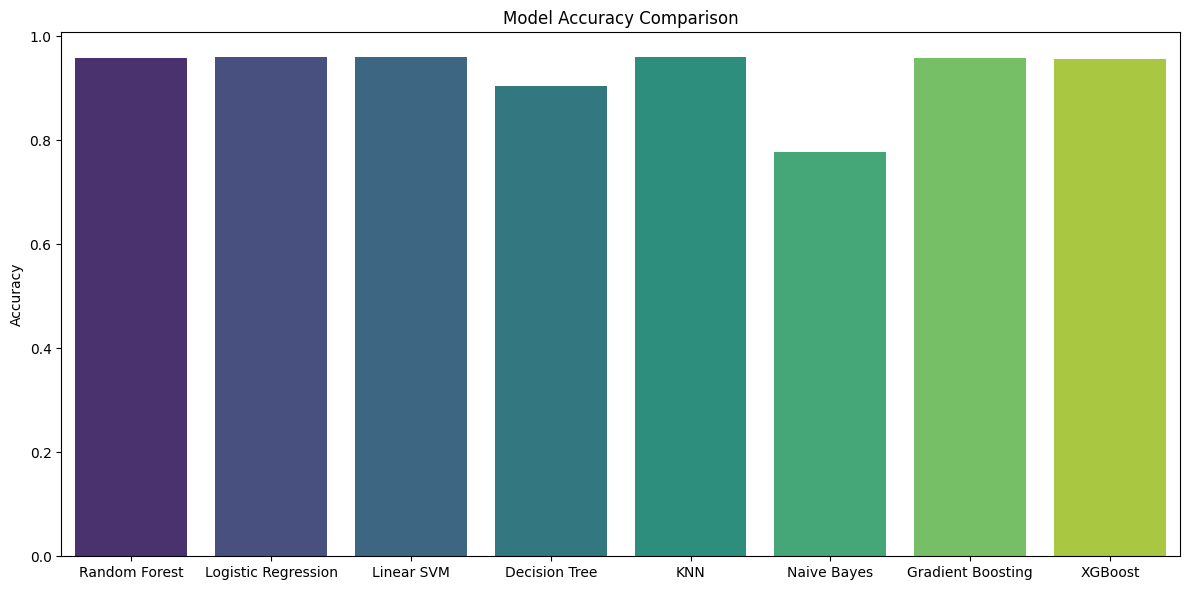

In [21]:
# @title Model Accuracy Comparison Plot
plt.figure(figsize=(12, 6))
sns.barplot(x=list(accuracy_results.keys()), y=list(accuracy_results.values()), palette='viridis', hue=list(accuracy_results.keys()), legend=False)
plt.ylabel('Accuracy')
plt.title('Model Accuracy Comparison')
plt.tight_layout()
plt.savefig('Model_Accuracy_Comparison.png', bbox_inches='tight')
plt.show()


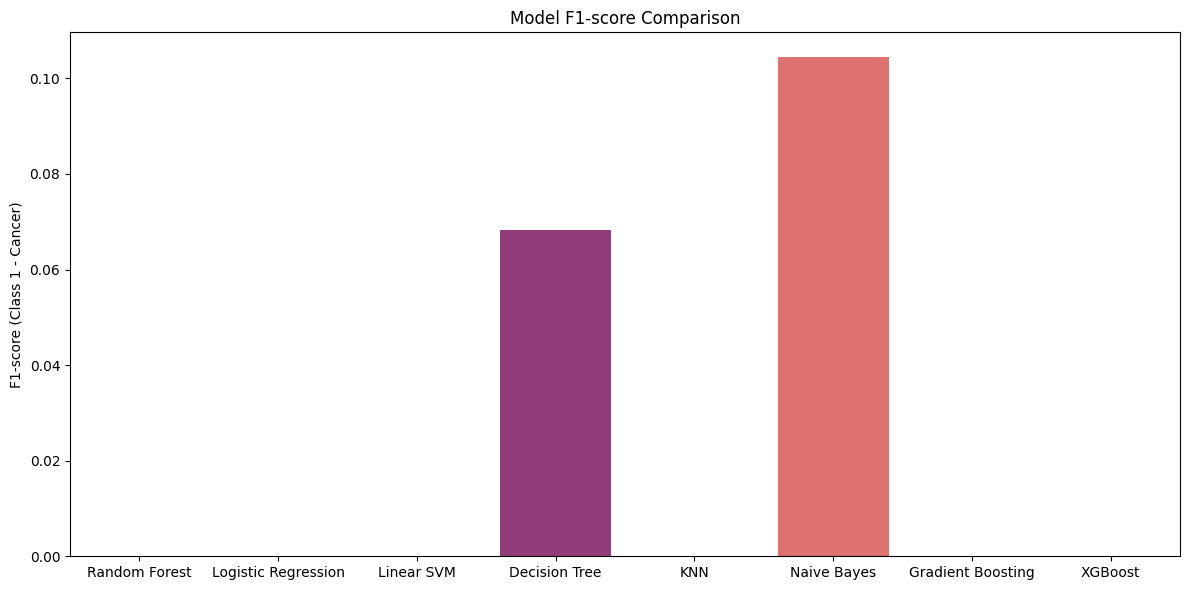

In [22]:
# @title Model F1-score Comparison Plot
plt.figure(figsize=(12, 6))
sns.barplot(x=list(f1_results.keys()), y=list(f1_results.values()), palette='magma', hue=list(f1_results.keys()), legend=False)
plt.ylabel('F1-score (Class 1 - Cancer)')
plt.title('Model F1-score Comparison')
plt.tight_layout()
plt.savefig('F1-score_Comparison_Plot.png', bbox_inches='tight')
plt.show()

In [23]:
# @title Model Training & Evaluation (With SMOTE)

# Apply SMOTE to training data
print("\n--- Applying SMOTE to training data for imbalance handling ---")
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

print(f"\nShape of X_train SMOTE: {X_train_resampled.shape}")
print(f"y_train class distribution SMOTE:\n{pd.Series(y_train_resampled).value_counts()}")

# Dictionary to store accuracy results for SMOTE models
accuracy_results_with_smote = {}
# New dictionary to store F1-scores with SMOTE
f1_results_with_smote = {}

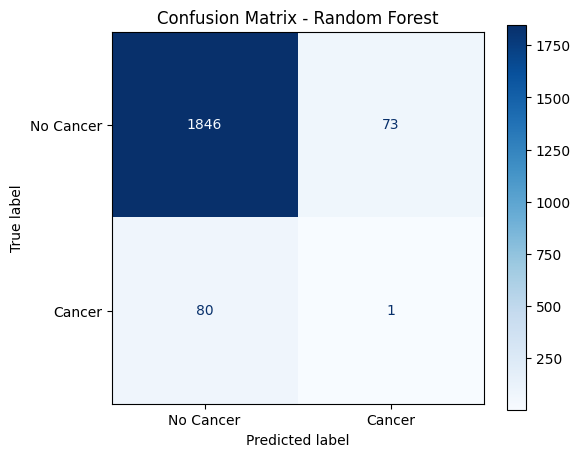

In [24]:
# @title Random Forest Classifier (With SMOTE)
name, acc = train_and_evaluate_model(
    'Random Forest',
    models['Random Forest'], # Use the pre-defined model instance
    X_train_resampled, y_train_resampled, X_test, y_test
)
accuracy_results_with_smote[name] = acc
f1_results_with_smote[name] = f1_score(y_test, models['Random Forest'].predict(X_test))

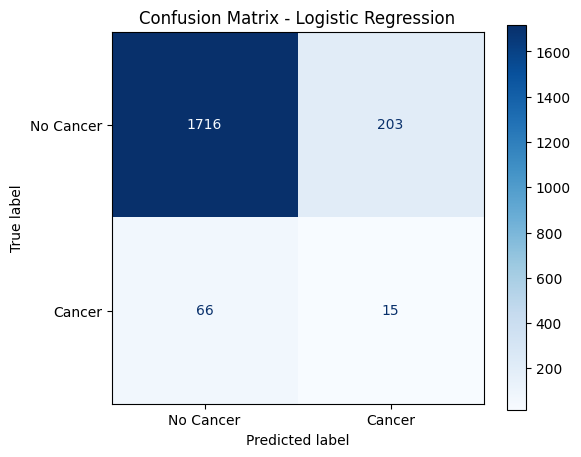

In [25]:
# @title Logistic Regression (With SMOTE)
name, acc = train_and_evaluate_model(
    'Logistic Regression',
    models['Logistic Regression'],
    X_train_resampled, y_train_resampled, X_test, y_test
)
accuracy_results_with_smote[name] = acc
f1_results_with_smote[name] = f1_score(y_test, models['Logistic Regression'].predict(X_test))

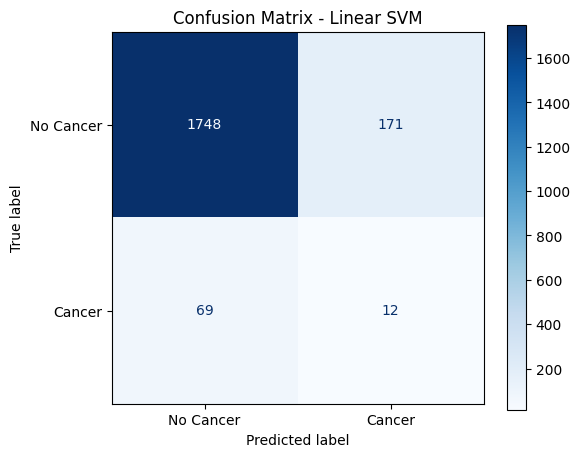

In [26]:
# @title Linear SVM (With SMOTE)
name, acc = train_and_evaluate_model(
    'Linear SVM',
    models['Linear SVM'],
    X_train_resampled, y_train_resampled, X_test, y_test
)
accuracy_results_with_smote[name] = acc
f1_results_with_smote[name] = f1_score(y_test, models['Linear SVM'].predict(X_test))

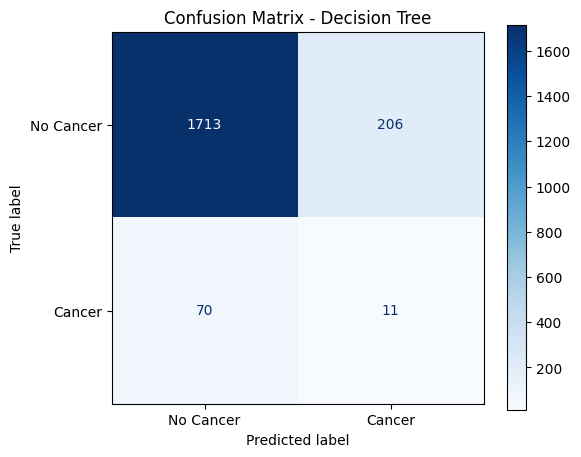

In [27]:
# @title Decision Tree Classifier (With SMOTE)
name, acc = train_and_evaluate_model(
    'Decision Tree',
    models['Decision Tree'],
    X_train_resampled, y_train_resampled, X_test, y_test
)
accuracy_results_with_smote[name] = acc
f1_results_with_smote[name] = f1_score(y_test, models['Decision Tree'].predict(X_test))

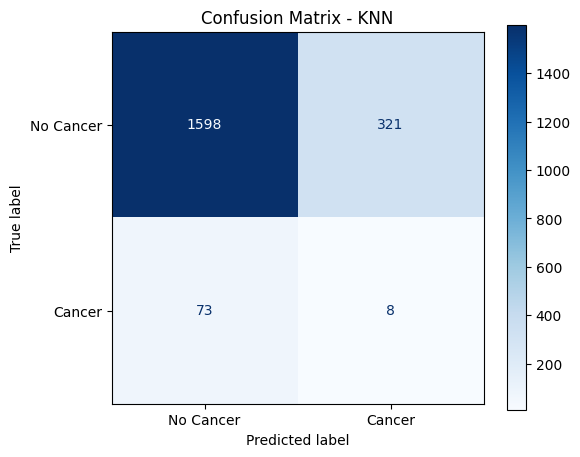

In [28]:
# @title K-Nearest Neighbors (KNN) (With SMOTE)
name, acc = train_and_evaluate_model(
    'KNN',
    models['KNN'],
    X_train_resampled, y_train_resampled, X_test, y_test
)
accuracy_results_with_smote[name] = acc
f1_results_with_smote[name] = f1_score(y_test, models['KNN'].predict(X_test))

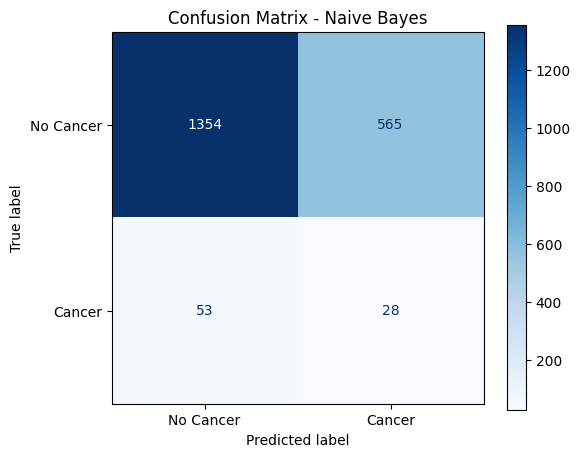

In [29]:
# @title Gaussian Naive Bayes (With SMOTE)
name, acc = train_and_evaluate_model(
    'Naive Bayes',
    models['Naive Bayes'],
    X_train_resampled, y_train_resampled, X_test, y_test
)
accuracy_results_with_smote[name] = acc
f1_results_with_smote[name] = f1_score(y_test, models['Naive Bayes'].predict(X_test))

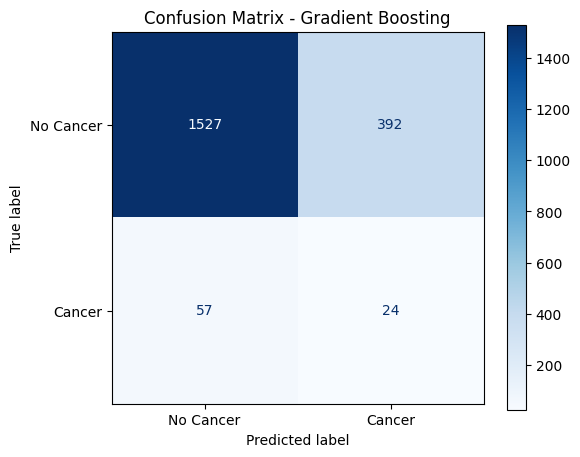

In [30]:
# @title Gradient Boosting Classifier (With SMOTE)
name, acc = train_and_evaluate_model(
    'Gradient Boosting',
    models['Gradient Boosting'],
    X_train_resampled, y_train_resampled, X_test, y_test
)
accuracy_results_with_smote[name] = acc
f1_results_with_smote[name] = f1_score(y_test, models['Gradient Boosting'].predict(X_test))

/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [17:51:23] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


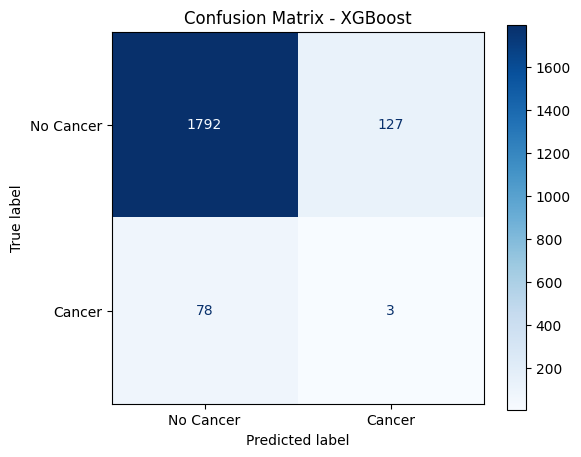

In [31]:
# @title XGBoost (With SMOTE)
name, acc = train_and_evaluate_model(
    'XGBoost',
    models['XGBoost'],
    X_train_resampled, y_train_resampled, X_test, y_test
)
accuracy_results_with_smote[name] = acc
f1_results_with_smote[name] = f1_score(y_test, models['XGBoost'].predict(X_test))


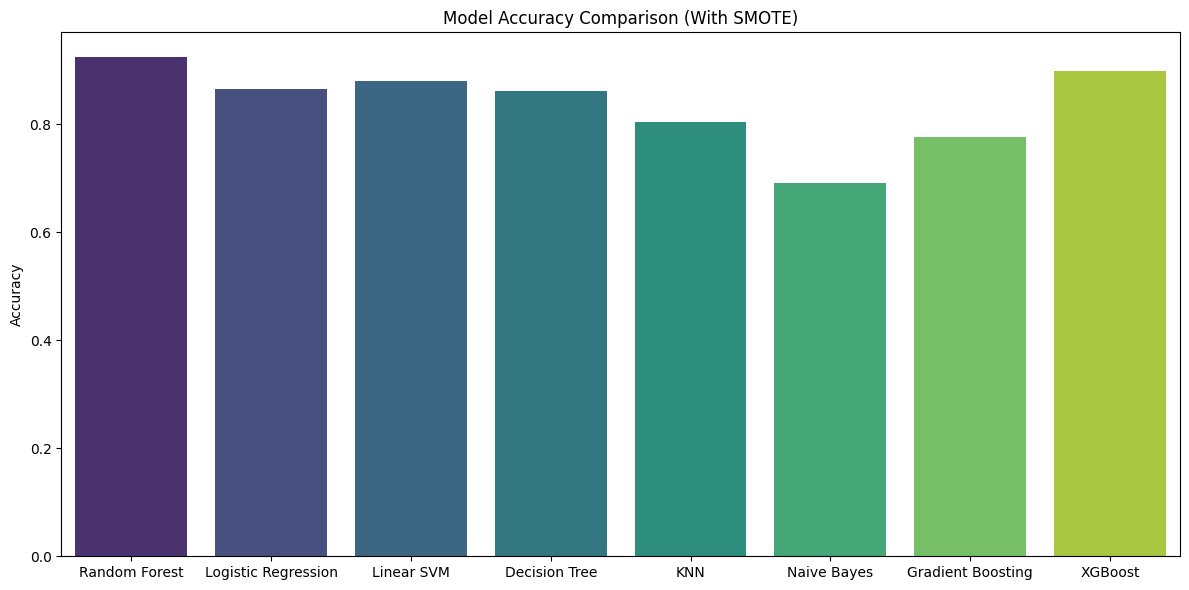

In [32]:
# @title Model Accuracy Comparison Plot (With SMOTE)
plt.figure(figsize=(12, 6))
sns.barplot(x=list(accuracy_results_with_smote.keys()), y=list(accuracy_results_with_smote.values()), palette='viridis', hue=list(accuracy_results_with_smote.keys()), legend=False)
plt.ylabel('Accuracy')
plt.title('Model Accuracy Comparison (With SMOTE)')
plt.tight_layout()
plt.savefig('Model_Accuracy_Comparison_With_SMOTE.png', bbox_inches='tight')
plt.show()

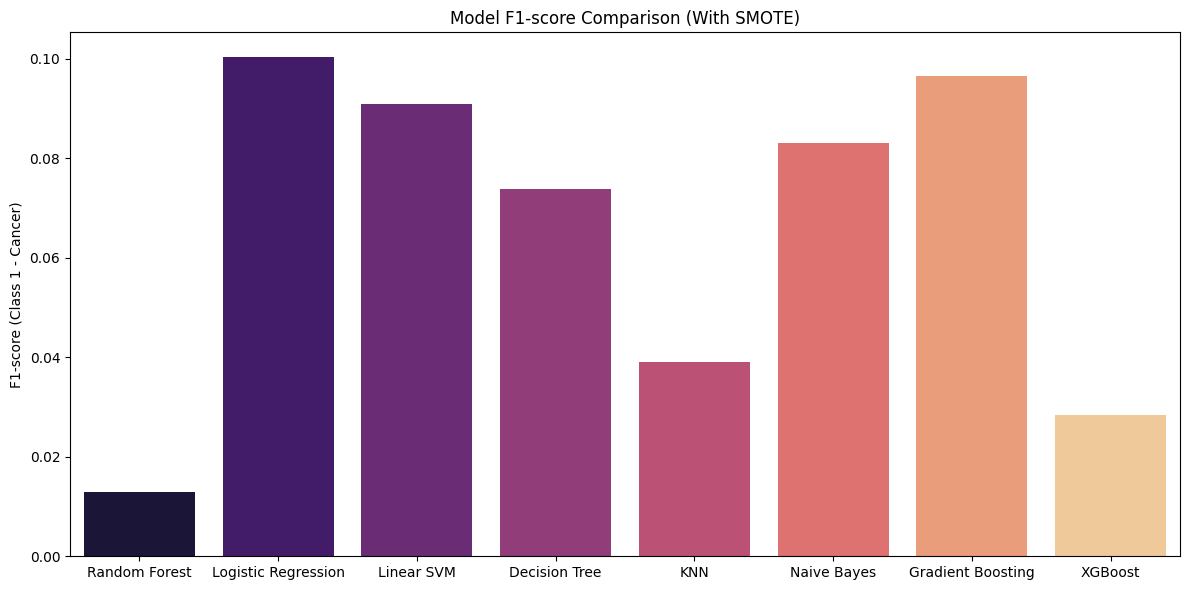

In [33]:
# @title Model F1-score Comparison Plot (With SMOTE)
plt.figure(figsize=(12, 6))
sns.barplot(x=list(f1_results_with_smote.keys()), y=list(f1_results_with_smote.values()), palette='magma', hue=list(f1_results_with_smote.keys()), legend=False)
plt.ylabel('F1-score (Class 1 - Cancer)')
plt.title('Model F1-score Comparison (With SMOTE)')
plt.tight_layout()
plt.savefig('F1-score_Comparison_Plot_With_SMOTE.png', bbox_inches='tight')
plt.show()

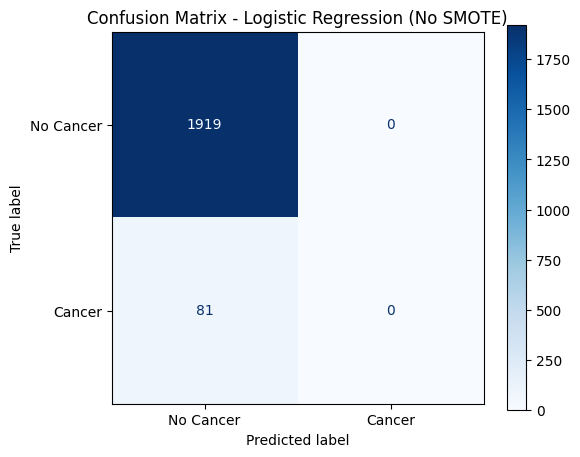

In [34]:
# @title Logistic Regression with Cross-Validation (No SMOTE)
print("\n--- Logistic Regression with Cross-Validation (No SMOTE) ---")

log_model = models['Logistic Regression'] # Reuse the instance from the global models dict
# cross_val_score internally re-initializes/clones the estimator for each fold, so it's fine.
# Changed scoring from 'accuracy' to 'f1'
cv_scores = cross_val_score(log_model, X_train, y_train, cv=5, scoring='f1', n_jobs=-1)
print("Logistic Regression Cross-Validation F1 Scores (No SMOTE):", cv_scores)
print(f"Mean CV F1 (No SMOTE): {cv_scores.mean():.4f}")

# Fit on full training data and evaluate on test set
log_model.fit(X_train, y_train)
y_pred_log_before = log_model.predict(X_test)

print("\nLogistic Regression Test Accuracy (No SMOTE):", accuracy_score(y_test, y_pred_log_before))
print("Logistic Regression Test F1-score (No SMOTE):", f1_score(y_test, y_pred_log_before)) # Added F1-score print

# Classification Report
report_dict_log_before = classification_report(y_test, y_pred_log_before, output_dict=True, zero_division=0)
report_df_log_before = pd.DataFrame(report_dict_log_before).transpose()
print("Classification Report (No SMOTE):\n", report_df_log_before)

# Confusion Matrix
fig, ax = plt.subplots(figsize=(6, 5))
cm_log_before = confusion_matrix(y_test, y_pred_log_before)
disp_log_before = ConfusionMatrixDisplay(confusion_matrix=cm_log_before, display_labels=['No Cancer', 'Cancer'])
disp_log_before.plot(cmap='Blues', ax=ax)
plt.title("Confusion Matrix - Logistic Regression (No SMOTE)")
plt.grid(False)
plt.savefig('Logistic_Regression_Confusion_Matrix_No_SMOTE.png', bbox_inches='tight')
plt.show()

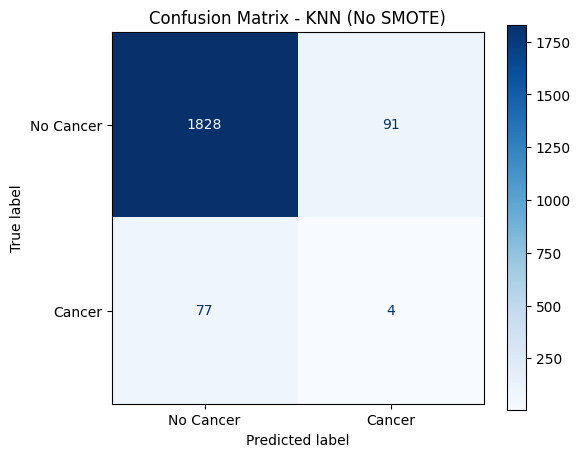

In [35]:
# @title KNN Hyperparameter Tuning using GridSearchCV (No SMOTE)
print("\n--- KNN Hyperparameter Tuning using GridSearchCV (No SMOTE) ---")

knn = models['KNN'] # Reuse the instance from the global models dict
param_grid_knn = {'n_neighbors': list(range(1, 21))}
# Change scoring from 'accuracy' to 'f1'
grid = GridSearchCV(knn, param_grid_knn, cv=5, scoring='f1', n_jobs=-1, verbose=1) # Added verbose for progress
grid.fit(X_train, y_train) # Fit with original data

print("\nBest K for KNN (No SMOTE):", grid.best_params_)
print(f"Best Cross-Validation Score (F1) for KNN (No SMOTE): {grid.best_score_:.4f}")

best_knn_before_smote = grid.best_estimator_
y_pred_knn_before = best_knn_before_smote.predict(X_test)

print("\nKNN Test Accuracy (No SMOTE):", accuracy_score(y_test, y_pred_knn_before))

# Classification Report
report_dict_knn_before = classification_report(y_test, y_pred_knn_before, output_dict=True, zero_division=0)
report_df_knn_before = pd.DataFrame(report_dict_knn_before).transpose()
print("Classification Report (No SMOTE):\n", report_df_knn_before)

# Confusion Matrix
fig, ax = plt.subplots(figsize=(6, 5))
cm_knn_before = confusion_matrix(y_test, y_pred_knn_before)
disp_knn_before = ConfusionMatrixDisplay(confusion_matrix=cm_knn_before, display_labels=['No Cancer', 'Cancer'])
disp_knn_before.plot(cmap='Blues', ax=ax)
plt.title("Confusion Matrix - KNN (No SMOTE)")
plt.grid(False)
plt.savefig('KNN_Confusion_Matrix_No_SMOTE.png', bbox_inches='tight')
plt.show()

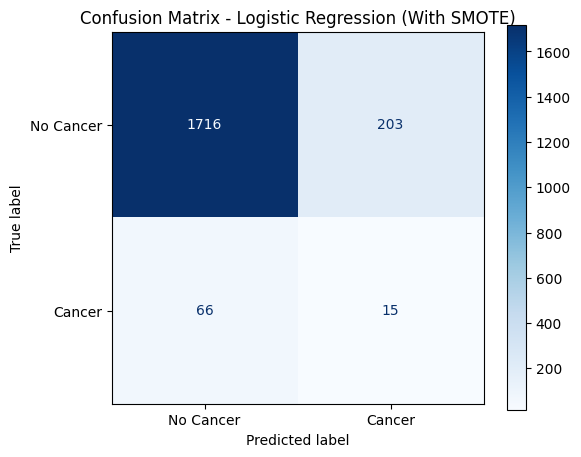

In [36]:
# @title Logistic Regression with Cross-Validation (With SMOTE)
print("\n--- Logistic Regression with Cross-Validation (With SMOTE) ---")

log_model_with_smote = models['Logistic Regression'] # Reuse the same instance
# cross_val_score for Logistic Regression with SMOTE (no GridSearchCV for LR in your provided code, so this remains for cross_val_score)
cv_scores_with_smote = cross_val_score(log_model_with_smote, X_train_resampled, y_train_resampled, cv=5, scoring='f1', n_jobs=-1) # Changed scoring to 'f1'
print("Logistic Regression Cross-Validation F1 Scores (With SMOTE):", cv_scores_with_smote)
print(f"Mean CV F1 (With SMOTE): {cv_scores_with_smote.mean():.4f}")

# Fit on full resampled training data and evaluate on test set
log_model_with_smote.fit(X_train_resampled, y_train_resampled)
y_pred_log_after = log_model_with_smote.predict(X_test)

print("\nLogistic Regression Test Accuracy (With SMOTE):", accuracy_score(y_test, y_pred_log_after)) # Accuracy here is fine for overall view
print("Logistic Regression Test F1-score (With SMOTE):", f1_score(y_test, y_pred_log_after)) # Add F1 for direct comparison

# Classification Report
report_dict_log_after = classification_report(y_test, y_pred_log_after, output_dict=True, zero_division=0)
report_df_log_after = pd.DataFrame(report_dict_log_after).transpose()
print("Classification Report (With SMOTE):\n", report_df_log_after)

# Confusion Matrix
fig, ax = plt.subplots(figsize=(6, 5))
cm_log_after = confusion_matrix(y_test, y_pred_log_after)
disp_log_after = ConfusionMatrixDisplay(confusion_matrix=cm_log_after, display_labels=['No Cancer', 'Cancer'])
disp_log_after.plot(cmap='Blues', ax=ax)
plt.title("Confusion Matrix - Logistic Regression (With SMOTE)")
plt.grid(False)
plt.savefig('Logistic_Regression_Confusion_Matrix_With_SMOTE.png', bbox_inches='tight')
plt.show()


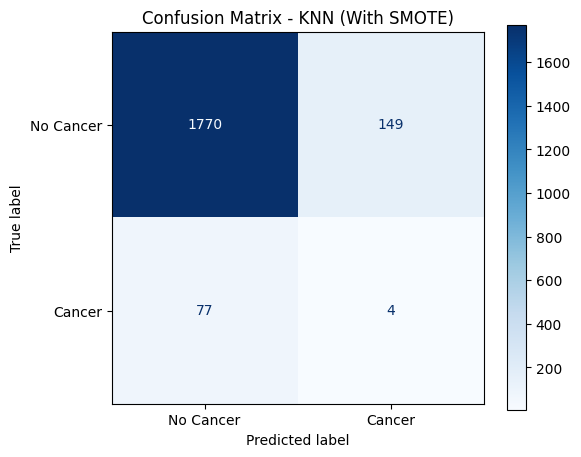

In [37]:
# @title KNN Hyperparameter Tuning using GridSearchCV (With SMOTE)
print("\n--- KNN Hyperparameter Tuning using GridSearchCV (With SMOTE) ---")

knn_with_smote = models['KNN'] # Reuse the same instance
# param_grid_knn is already defined globally, so no need to redefine
# Change scoring from 'accuracy' to 'f1'
grid_with_smote = GridSearchCV(knn_with_smote, param_grid_knn, cv=5, scoring='f1', n_jobs=-1, verbose=1)
grid_with_smote.fit(X_train_resampled, y_train_resampled) # Fit with resampled data

print("\nBest K for KNN (With SMOTE):", grid_with_smote.best_params_)
print(f"Best Cross-Validation Score (F1) for KNN (With SMOTE): {grid_with_smote.best_score_:.4f}")

best_knn_with_smote = grid_with_smote.best_estimator_
y_pred_knn_after = best_knn_with_smote.predict(X_test)

print("\nKNN Test Accuracy (With SMOTE):", accuracy_score(y_test, y_pred_knn_after))
print("KNN Test F1-score (With SMOTE):", f1_score(y_test, y_pred_knn_after)) # Add F1 for direct comparison

# Classification Report
report_dict_knn_after = classification_report(y_test, y_pred_knn_after, output_dict=True, zero_division=0)
report_df_knn_after = pd.DataFrame(report_dict_knn_after).transpose()
print("Classification Report (With SMOTE):\n", report_df_knn_after)

# Confusion Matrix
fig, ax = plt.subplots(figsize=(6, 5))
cm_knn_after = confusion_matrix(y_test, y_pred_knn_after)
disp_knn_after = ConfusionMatrixDisplay(confusion_matrix=cm_knn_after, display_labels=['No Cancer', 'Cancer'])
disp_knn_after.plot(cmap='Blues', ax=ax)
plt.title("Confusion Matrix - KNN (With SMOTE)")
plt.grid(False)
plt.savefig('KNN_Confusion_Matrix_With_SMOTE.png', bbox_inches='tight')
plt.show()

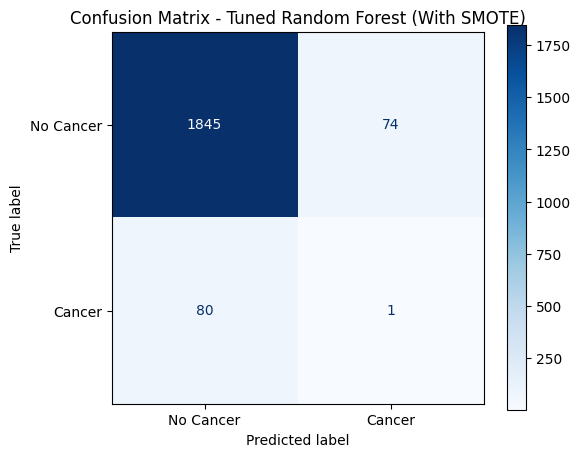

In [38]:

# @title Random Forest Hyperparameter Tuning using GridSearchCV (With SMOTE)
print("\n--- Random Forest Hyperparameter Tuning using GridSearchCV (With SMOTE) ---")

rf_model = models['Random Forest']
param_grid_rf = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20, None], # None means nodes are expanded until all leaves are pure or until all leaves contain less than min_samples_split samples.
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}
# Use 'f1' for scoring to optimize for the minority class
grid_rf_smote = GridSearchCV(rf_model, param_grid_rf, cv=3, scoring='f1', n_jobs=-1, verbose=1) # Reduced CV to 3 for quicker execution
grid_rf_smote.fit(X_train_resampled, y_train_resampled)

print("\nBest parameters for Random Forest (With SMOTE):", grid_rf_smote.best_params_)
print(f"Best CV F1-score for Random Forest (With SMOTE): {grid_rf_smote.best_score_:.4f}")

best_rf_smote = grid_rf_smote.best_estimator_
y_pred_rf_tuned = best_rf_smote.predict(X_test)

print("\nRandom Forest Tuned Test Accuracy (With SMOTE):", accuracy_score(y_test, y_pred_rf_tuned))
print("Random Forest Tuned Test F1-score (With SMOTE):", f1_score(y_test, y_pred_rf_tuned))

print("Classification Report (With SMOTE, Tuned RF):\n", classification_report(y_test, y_pred_rf_tuned))

fig, ax = plt.subplots(figsize=(6, 5))
cm_rf_tuned = confusion_matrix(y_test, y_pred_rf_tuned)
disp_rf_tuned = ConfusionMatrixDisplay(confusion_matrix=cm_rf_tuned, display_labels=['No Cancer', 'Cancer'])
disp_rf_tuned.plot(cmap='Blues', ax=ax)
plt.title("Confusion Matrix - Tuned Random Forest (With SMOTE)")
plt.grid(False)
plt.savefig('Tuned_Random_Forest_Confusion_Matrix_With_SMOTE.png', bbox_inches='tight')
plt.show()

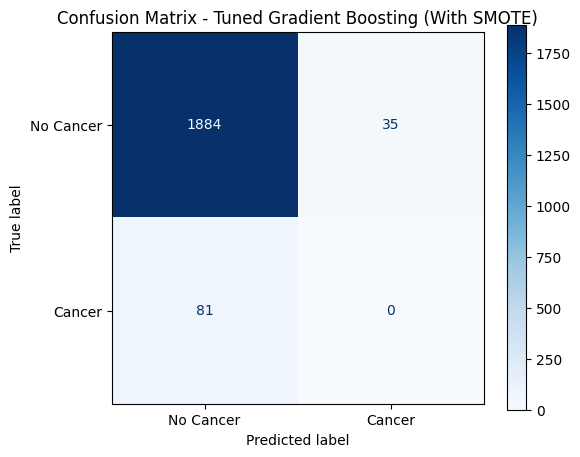

In [39]:
# @title Gradient Boosting Hyperparameter Tuning using GridSearchCV (With SMOTE)
print("\n--- Gradient Boosting Hyperparameter Tuning using GridSearchCV (With SMOTE) ---")

gb_model = models['Gradient Boosting']
param_grid_gb = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7],
    'subsample': [0.8, 1.0]
}
# Use 'f1' for scoring to optimize for the minority class
grid_gb_smote = GridSearchCV(gb_model, param_grid_gb, cv=3, scoring='f1', n_jobs=-1, verbose=1) # Reduced CV to 3
grid_gb_smote.fit(X_train_resampled, y_train_resampled)

print("\nBest parameters for Gradient Boosting (With SMOTE):", grid_gb_smote.best_params_)
print(f"Best CV F1-score for Gradient Boosting (With SMOTE): {grid_gb_smote.best_score_:.4f}")

best_gb_smote = grid_gb_smote.best_estimator_
y_pred_gb_tuned = best_gb_smote.predict(X_test)

print("\nGradient Boosting Tuned Test Accuracy (With SMOTE):", accuracy_score(y_test, y_pred_gb_tuned))
print("Gradient Boosting Tuned Test F1-score (With SMOTE):", f1_score(y_test, y_pred_gb_tuned))

print("Classification Report (With SMOTE, Tuned Gradient Boosting):\n", classification_report(y_test, y_pred_gb_tuned))

fig, ax = plt.subplots(figsize=(6, 5))
cm_gb_tuned = confusion_matrix(y_test, y_pred_gb_tuned)
disp_gb_tuned = ConfusionMatrixDisplay(confusion_matrix=cm_gb_tuned, display_labels=['No Cancer', 'Cancer'])
disp_gb_tuned.plot(cmap='Blues', ax=ax)
plt.title("Confusion Matrix - Tuned Gradient Boosting (With SMOTE)")
plt.grid(False)
plt.savefig('Tuned_Gradient_Boosting_Confusion_Matrix_With_SMOTE.png', bbox_inches='tight')
plt.show()

In [40]:
end_time = time.time()
total_time = end_time - start_time

print(f"\n--- Total execution time: {total_time:.2f} seconds ---") # Print after restoring stdout


# Ensure the logger is closed before printing the final message to stdout
if 'logger' in globals() and logger is not None:
    sys.stdout.flush()
    sys.stdout = sys.__stdout__  # Restore default output
    logger.close()

print("✅ Logging completed. Output saved to lung_cancer_prediction_output.txt.")